### Extracting Narrative Topics in Facebook Groups

Extracting narrative topics from social media discourse is notoriously difficult. Most topical modelling algorithms are designed to extract topics from structured, formally-written, coherent narratives, e.g. a newspaper article, a book chapter, etc. However, social media data is unstructured, informal, and often incoherent, i.e. a series of posts in one Facebook group may be sentence fragments on differing topics and contain spelling errors, slang, and emojis. This can make the process of identifying narrative topics on social media challenging at best. 

To be able to identify (relatively) logical narrative topics from social media discourse, the following steps must be taken:

* Like-minded groups engaged need be identified. While this doesn't eliminate topical incoherence, but it helps to significantly reduce it.
* Given the dynamics of social media, topics emerge, disappear, and new topics emerge in short periods of time, thus a logical window of time should be selected to avoid messy data.
* Posts from these groups must be pre-processed ('cleaned' and 'tokenized') to remove punctuation, symbols, and 'stop words', i.e. words that are so common that they do not add meaningful context (prepositions, conjunctions, etc.)*
* Once posts are pre-processed, the keywords that appear most frequently (topics) must be extracted. Alternatively, if you are interested in discourse on a particular topic, you can analyze discourse related to specific keyword of your choice, i.e., a person, location, event, etc.
* Words used often in association with the topics must be identified in some manner, e.g. word covariance, word correlation, etc.

**The removal of stop words can be challenging for two reasons: 1) some languages do not permit for easy word 'segmentation' to isolate stop words, such as Burmese, and 2) lists of stop words are not readily available for what are considered 'low-resource' languages, such as Oromo. In the case of the former, topic analysis using algorithmic methods is exceptionally difficult; in the case of the latter, stop word lists can be compiled manually to facilitate pre-processing.*

These automated methods can only take you so far: once topics are extracted and associated words are identified, manual analysis is necessary to contextualize the topics and associated words to identify logical narratives and assess their significance!

In this example, we will extract topics in the community of pro-Georgia Republican Facebook Groups we identified using  community detection in *2. Conducting Social Network Analysis & Community Detection in Facebook Groups*. We'll extract topics and associated words from the posts data collected and stored in our database in *3. Analyzing Media Sources and Articles in Facebook Groups*



First, we import packages needed for script and add a database connection to collect posts we stored from our community of groups.

In [1]:
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pyodbc 
from sqlalchemy import create_engine
import re
import networkx as nx
import matplotlib.pyplot as plt
import string

connection_string = "your_connection_string"
engine = create_engine(connection_string, encoding='utf8')
db = engine.connect()

We grab the data from our database and remove any rows where message is null

In [2]:
ga_rep_group_posts = pd.read_sql_table("ga_republican_groups_posts", con=db)
ga_rep_group_posts = ga_rep_group_posts[ga_rep_group_posts['message'].notnull()]

We'll have a quick peek at the messages before we pre-process them for analysis.

In [3]:
ga_rep_group_posts[['date','message']].head(20)

,date,message
1,2020-12-19 01:07:43,Official White House Photo (by Andrea Hanks)
3,2020-12-26 02:29:16,????????
5,2020-12-19 22:48:08,Praying for you Mr President!! Keep fighting!!...
6,2020-12-14 03:50:15,The man and his navy! And his army??!
15,2020-12-20 21:24:26,Very disrespectful!
16,2020-12-18 00:29:23,Georgia just announced a full statewide signat...
20,2020-12-22 23:17:35,My daughter and I just exercised our right and...
25,2020-12-17 23:38:04,4 More Years ????????
27,2020-12-23 02:19:21,YES!!
28,2020-12-17 20:36:15,I did my part in Ga and voted red.


From this tiny peek, it looks like we have a number of posts about voting, Trump, and a couple about Christmas (which makes sense given the time window). 

We also have some punctuation and stop words that need to be removed.

We upload a csv file of custom 'stop words' that we obtained from the R TidyText library (https://github.com/juliasilge/tidytext). NB: it is not necessary to use a custom list of stop words for this example since the Python natural language processing toolkit (NLTK) has a list of English-language stop words that we can leverage. However, for low-resource languages, uploading a custom list of stop words may be necessary.

In [4]:
stopwords = pd.read_csv("stopwords.csv")
stopwords = set(stopwords['word'])

We create a 'clean_text' function that converts all text to lowercase and removes stop words, urls, punctuation, etc. from the text.

In [5]:
def clean_text(data):
  data = data.lower() #this may trigger a  warning...
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  data = data.encode('ascii', 'ignore').decode()
  data = re.sub(r'https*\S+', ' ', data)
  data = re.sub(r'@\S+', ' ', data)
  data = re.sub(r'#\S+', ' ', data)
  data = re.sub(r'\'\w+', '', data)
  data = re.sub('[%s]' % re.escape(string.punctuation), ' ', data)
  data = re.sub(r'\w*\d+\w*', '', data)
  data = re.sub(r'\s{2,}', ' ', data)
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  return data

Now we store the cleaned text in new column in our dataset called 'text' (and we'll take a peek at what the cleaned data looks like)

In [6]:
ga_rep_group_posts['text'] = ga_rep_group_posts['message'].apply(clean_text) 
ga_rep_group_posts = ga_rep_group_posts[ga_rep_group_posts['text'].notnull()]
ga_rep_group_posts['text'].reset_index(drop=True).head(20)

0              official white house photo andrea hanks 
1                                                      
2                           praying president fighting 
3                                            navy army 
4                                        disrespectful 
5          georgia announced statewide signature audit 
6     daughter exercised privilege vote hopes preser...
7                                                      
8                                                      
9                                         ga voted red 
10                             family voted red friday 
11    faith current president criminal bought donald...
12       trump girl trump middle class georgia vote red
13     brother sister american patriots merry christmas
14                                                     
15                                quote famous georgia 
16         favorite christmas daughter hope generation 
17                                           vot

Now that the text has been stripped of punctuation and stop words, we can extract which keywords are most frequently used. We grab the most commonly appearing words in the words in the corpus and take a peek.

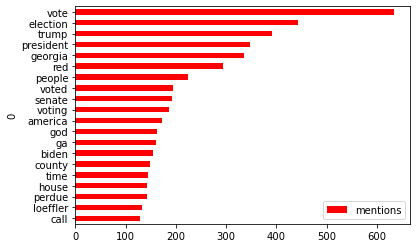

In [7]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(ga_rep_group_posts['text'], 20)
#for word, freq in common_words:
#    print(word, freq)
common_words_df = pd.DataFrame(common_words)
fig, ax = plt.subplots()
common_words_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"])

We can see that the most prominent topics relate to voting, Trump, and the Georgia Republican senate candidates.

*For illustrative purposes, we can also look at the most frequently used two-word phrases (bigrams) in the text (although we won't use bigrams for this topic analysis, sometimes using bigrams as topics is more interesting - and enlightening - than using individual keywords)

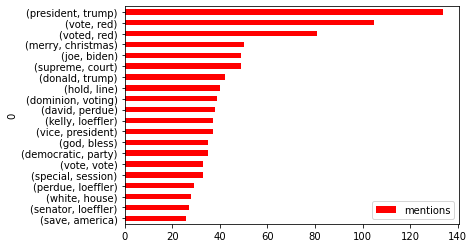

In [8]:
bigrams = [(x, i.split()[j + 1]) for i in ga_rep_group_posts['text']  
       for j, x in enumerate(i.split()) if j < len(i.split()) - 1]
frequency_dist_bigrams = FreqDist(bigrams)
common_bigrams_df = pd.DataFrame(frequency_dist_bigrams.most_common(20))
fig, ax = plt.subplots()
common_bigrams_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"]);

Mentions of Trump seem to be most frequent along with variations of 'vote red' or 'voted red' are actually just as prominent. References to electoral fraud (e.g. dominion voting, special session) are also quite prominent.  

To find which words are used in relation with some of our topic keywords, we'll create We convert our corpus of text into a 'vector matrix' where:

* Every row is a numbered post from the corpus (post 1, post 2, post 3, etc.)
* Every column header is a word that appears somewhere in the corpus
* Each value in the matrix is a '1' or '0', depending on whether or not a word appears in the numbered post

e.g. If post 1 is "hello world", columns with headers 'hello' and 'world' will be marked with a '1'.

(for efficiency, we'll exlude: words that are less than 3 characters in the text and words that appear less than 10 times in all messages)

In [106]:
# Only alphabet, contains at least 3 letters, and appears > 10 times in the text
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 1),
                              min_df=10)
count_vectorized = vectorizer.fit_transform(ga_rep_group_posts['text'])
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
vectorized = tfidf_transformer.fit_transform(count_vectorized)
vector_matrix = pd.DataFrame(vectorized.toarray(), 
             index=['message '+str(i) 
                    for i in range(1, 1+len(ga_rep_group_posts['text']))],
             columns=vectorizer.get_feature_names())

To determine how frequently one word appears in the text with other words, we create a 'covariance matrix' from our vector matrix where:

* Every row and every column corresponds to a word in the text
* The more often two words appear together in the text, the higher their covariance (on a scale between -1 and 1)

e.g., if 'world' appears in every post that contains the word 'hello', their covariance would be 1; if 'goodbye' does not appear in any posts that contains the word 'hello', their covariance would be -1.

In [107]:
pairwise_cov_matrix = vector_matrix.cov()

We'll convert our covariance matrix to a correlation matrix to determine the strength of the relationships between words in the text, i.e. word association. Similar to covariance, the closer the correlation is to 1, the stronger the relationship. 

In [113]:
pairwise_cor = np.corrcoef(pairwise_cov_matrix)
words = list(pairwise_cov_matrix.columns) 
pairwise_cor_matrix = pd.DataFrame(pairwise_cor, columns = words, index = words)

We'll create a function called 'corr_network' to isolate the most frequently mentioned keywords (topics) and words that appear with those words in the text. Then we select the 10 words with the highest covariance with or topics (and we'll peek at which words have the highest covariance with one of the topic keywords)

In [151]:
def corr_network(matrix, topics, words):
    temp_mat = matrix[matrix.index.isin(topics)]
    temp_df = pd.DataFrame(temp_mat.T.unstack().reset_index(name='correlation').sort_values('correlation', ascending=False))
    temp_df = temp_df.rename(columns={"level_0": 'topic', "level_1": 'word'})
    temp_df = temp_df.sort_values(['topic','correlation'], ascending=False).reset_index(drop=True)
    temp_df = temp_df[temp_df['topic'] != temp_df['word']]
    return temp_df.groupby(['topic'],as_index=False).apply(lambda x: x.nlargest(words, 'correlation'))

pairwise_cor_network = corr_network(pairwise_cor_matrix, common_words_df[0], 10)


We can take a look at what words are most closely associated with the topic keyword 'biden' in our data:

In [153]:
pairwise_cor_network[pairwise_cor_network['topic'] == 'biden']

topic       word  correlation
1 10320  biden        joe     0.711040
  10321  biden     hunter     0.545430
  10322  biden    corrupt     0.467561
  10323  biden     debate     0.364503
  10324  biden   millions     0.336061
  10325  biden      elect     0.323925
  10326  biden  president     0.262961
  10327  biden      obama     0.252945
  10328  biden    opinion     0.252718
  10329  biden  authority     0.251164

We can see that the word most frequently associated with 'biden' is 'joe', followed by 'hunter' and 'corrupt', which seems to make sense given the prevalence of attack narratives aimed at portraying Joe and Hunter Biden as engaged in corruption.

Finally, we create a social network graph that highlights the relationships between topics and associated words -- the closer words appear together on the graph, the stronger the relationship between those words. In some cases, words may be associated with multiple topics and thus there may be lines (edges) connecting to multiple dots (nodes) on the graph.

Note: we'll remove words that have weak correlation to reduce noise in our graph

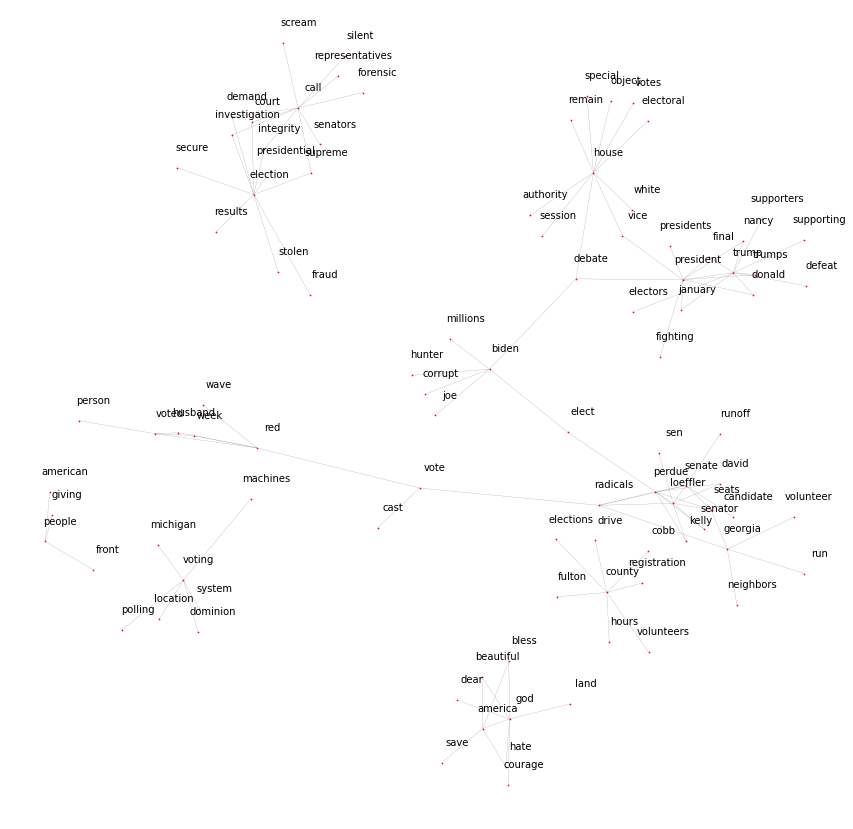

In [154]:
np.random.seed(2020)
pairwise_cor_network_clean = pairwise_cor_network[pairwise_cor_network['correlation'] > 0.3]
G = nx.from_pandas_edgelist(pairwise_cor_network_clean, source='word', target='topic', edge_attr=True)
fig, ax = plt.subplots(figsize=(15, 15))

#pos = nx.spring_layout(G, k=10/G.order())
#pos = nx.spiral_layout(G)
pos = nx.fruchterman_reingold_layout(G, k=20/G.order())
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=8,
                 width=0.2,
                 node_size = 0.5,
                 edge_color='grey',
                 node_color='red',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=10)
    
plt.axis('off')
plt.show()

The graph shows that much of the discussion remains dominated by allegations related to voter fraud in the 2020 presidential election, i.e. calls for special session of the Georgia Assembly, Dominion voting machines, etc. We also see mentions of Joe and Hunter Biden associated with 'corrupt.' And we see some some mention related to elections ('registration' and 'drive'), voting ('vote red'), and supporting candidates ('elect', 'volunteer' associated with 'loeffler' and 'perdue'). 

We can drill down into discussion related to specific topics of interest that do not appear on the graph. For example, if we want to see how Democratic Senate Candidates Raphael Warnock and Jon Ossoff are being discussed, we could extract 'Warnock' and 'Ossoff' from our correlation matrix and extract the top 20 words associated with them.

In [158]:
pairwise_cor_warnock_ossoff = corr_network(pairwise_cor_matrix, ['warnock','ossoff'], 20)

First, we'll look at words associated with 'Ossoff'

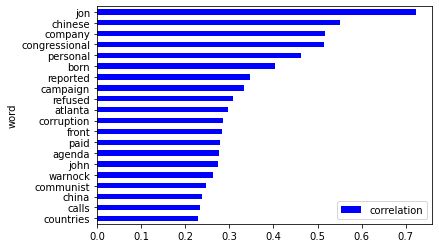

In [166]:
ossoff_topic = pairwise_cor_warnock_ossoff[pairwise_cor_warnock_ossoff['topic']=='ossoff']
ossoff_topic.plot.barh(x='word', y='correlation', color='b').invert_yaxis()

Variations on China, corruption, and communist are all related to mentions of Ossoff. Mentions of China and corrpution are ostensibly related to allegations that Ossoff received funding from the Chinese government for nefarious reasons. Mentions of 'communist' are likely linked to attacks related to China (or perhaps broader attacks aimed at portraying Ossoff as a radical socialist)

Now let's take a look at words associated with Warnock.

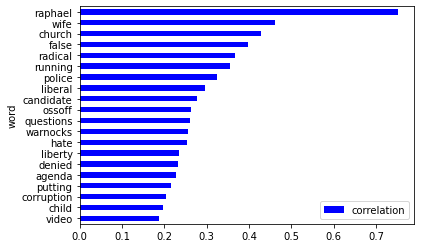

In [167]:
warnock_topic = pairwise_cor_warnock_ossoff[pairwise_cor_warnock_ossoff['topic']=='warnock']
warnock_topic.plot.barh(x='word', y='correlation', color='b').invert_yaxis()

Mentions of 'wife' and 'child' are associated with Warnock, likely related to allegations of domestic violence and child abuse levied against Warnock by Republican opponents and in the media. Mentions of 'liberal' and 'radical' are surely related to attacks aimed at portraying Warnock as a radical liberal! 